# <span style="color:white">**Projet ML - Bike Sharing**</span>

## <span style="color:powderblue">**Imports and Setup**</span>

### <span style="color:lightcyan">**Imports**</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor



#import sklearn.svm as svm
#import sklearn.feature_selection as feature_select
#import sklearn.feature_extraction as feature_extract
#import sklearn.preprocessing as preprocessing
#import sklearn.neural_network as nn

### <span style="color:lightcyan">**Data preparation**</span>

In [2]:
day_df = pd.read_csv("./data/day.csv",delimiter=";")
hour_df = pd.read_csv("./data/hour.csv",delimiter=";")
day_df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01/01/2011       1   0     1        0        6           0   
1        2  02/01/2011       1   0     1        0        0           0   
2        3  03/01/2011       1   0     1        0        1           1   
3        4  04/01/2011       1   0     1        0        2           1   
4        5  05/01/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
def extract_day_of_month(df, date_column):
    df["day"] = pd.to_datetime(df[date_column]).dt.day
    return df

In [7]:
#day_df = extract_day_of_month(day_df, "dteday")
#hour_df = extract_day_of_month(hour_df, "dteday")

day_df['dteday'] = pd.to_datetime(day_df.dteday, format = '%Y-%m-%d')
hour_df['dteday'] = pd.to_datetime(hour_df.dteday, format = '%Y-%m-%d')

ValueError: time data "01/01/2011" doesn't match format "%Y-%m-%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

### <span style="color:lightcyan">**Encoding Datetimes**</span>

In [ ]:
day_df['day_of_year'] = day_df['dteday'].dt.day_of_year
day_df['week_of_year'] = day_df['dteday'].dt.isocalendar().week
day_df['quarter'] = day_df['dteday'].dt.quarter

In [ ]:
hour_df['day_of_year'] = hour_df['dteday'].dt.day_of_year
hour_df['week_of_year'] = hour_df['dteday'].dt.isocalendar().week
hour_df['quarter'] = hour_df['dteday'].dt.quarter

In [ ]:
day_columns_order = ['instant','dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year'] + [col for col in day_df.columns if col not in ['instant', 'dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year']]
day_df = day_df[day_columns_order]
hour_columns_order = ['instant','dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year', "hr"] + [col for col in hour_df.columns if col not in ['instant', 'dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year','hr']]
hour_df = hour_df[hour_columns_order]

In [ ]:
day_df.columns = ["instant","date", "year", "season", "quarter",  "month", "week_of_year", "day", "day_of_year", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]
hour_df.columns = ["instant","date", "year", "season", "quarter", "month", "week_of_year", "day", "day_of_year", "hour", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]

In [ ]:
target = ["count"]
day_features = [feature for feature in day_df.columns if feature not in target]
hour_features = [feature for feature in hour_df.columns if feature not in target]

### <span style="color:lightcyan">**Encoding time as cyclical values**</span>

Encoding dates as cyclical values with cos and sin to ensure there is no drop of 30 for example when going from the last day of month n to the first day of month n+1

In [ ]:
month_in_year = 12
day_df['month_sin'] = np.sin(2*np.pi*day_df.month/month_in_year)
day_df['month_cos'] = np.cos(2*np.pi*day_df.month/month_in_year)

In [ ]:
days_in_month = 30.5
day_df['day_sin'] = np.sin(2*np.pi*day_df.day/days_in_month)
day_df['day_cos'] = np.cos(2*np.pi*day_df.day/days_in_month)

In [ ]:
days_in_year = 365
day_df['day_of_year_sin'] = np.sin(2*np.pi*day_df.day_of_year/days_in_year)
day_df['day_of_year_cos'] = np.cos(2*np.pi*day_df.day_of_year/days_in_year)

In [ ]:
weeks_in_year = 52.1429
day_df['week_of_year_sin'] = np.sin(2*np.pi*day_df.week_of_year/weeks_in_year)
day_df['week_of_year_cos'] = np.cos(2*np.pi*day_df.week_of_year/weeks_in_year)


In [ ]:
quarters_in_year = 4
day_df['quarter_sin'] = np.sin(2*np.pi*day_df.quarter/quarters_in_year)
day_df['quarter_cos'] = np.cos(2*np.pi*day_df.quarter/quarters_in_year)

In [ ]:
seasons_in_year = 4
day_df['season_sin'] = np.sin(2*np.pi*day_df.season/seasons_in_year)
day_df['season_cos'] = np.cos(2*np.pi*day_df.season/seasons_in_year)

In [ ]:
day_df.head()

instant       date  year  season  quarter  month  week_of_year  day  \
0        1 2011-01-01     0       1        1      1            52    1   
1        2 2011-01-02     0       1        1      1            52    2   
2        3 2011-01-03     0       1        1      1             1    3   
3        4 2011-01-04     0       1        1      1             1    4   
4        5 2011-01-05     0       1        1      1             1    5   

   day_of_year  holiday  ...   day_sin   day_cos  day_of_year_sin  \
0            1        0  ...  0.204552  0.978856         0.017213   
1            2        0  ...  0.400454  0.916317         0.034422   
2            3        0  ...  0.579421  0.815028         0.051620   
3            4        0  ...  0.733885  0.679273         0.068802   
4            5        0  ...  0.857315  0.514793         0.085965   

   day_of_year_cos  week_of_year_sin  week_of_year_cos  quarter_sin  \
0         0.999852         -0.017219          0.999852          1.0   
1         0.999407         -0.017219          0.999852          1.0   
2         0.998667          0.120208          0.992749          1.0   
3         0.997630          0.120208          0.992749          1.0   
4         0.996298          0.120208          0.992749          1.0   

    quarter_cos  season_sin    season_cos  
0  6.123234e-17         1.0  6.123234e-17  
1  6.123234e-17         1.0  6.123234e-17  
2  6.123234e-17         1.0  6.123234e-17  
3  6.123234e-17         1.0  6.123234e-17  
4  6.123234e-17         1.0  6.123234e-17  

[5 rows x 32 columns]

### <span style="color:lightcyan">**Seasonal Decomposition**</span>

In [ ]:
decompose_cols = ['temperature','felt_temperature','humidity','windspeed','weathersit','casual','registered','count']

for col in decompose_cols:
    decomp = seasonal_decompose(day_df[col],period = 365, model = 'additive', extrapolate_trend = 'freq')
    day_df[f'{col}_trend'] = decomp.trend
    day_df[f'{col}_seasonal'] = decomp.seasonal

example

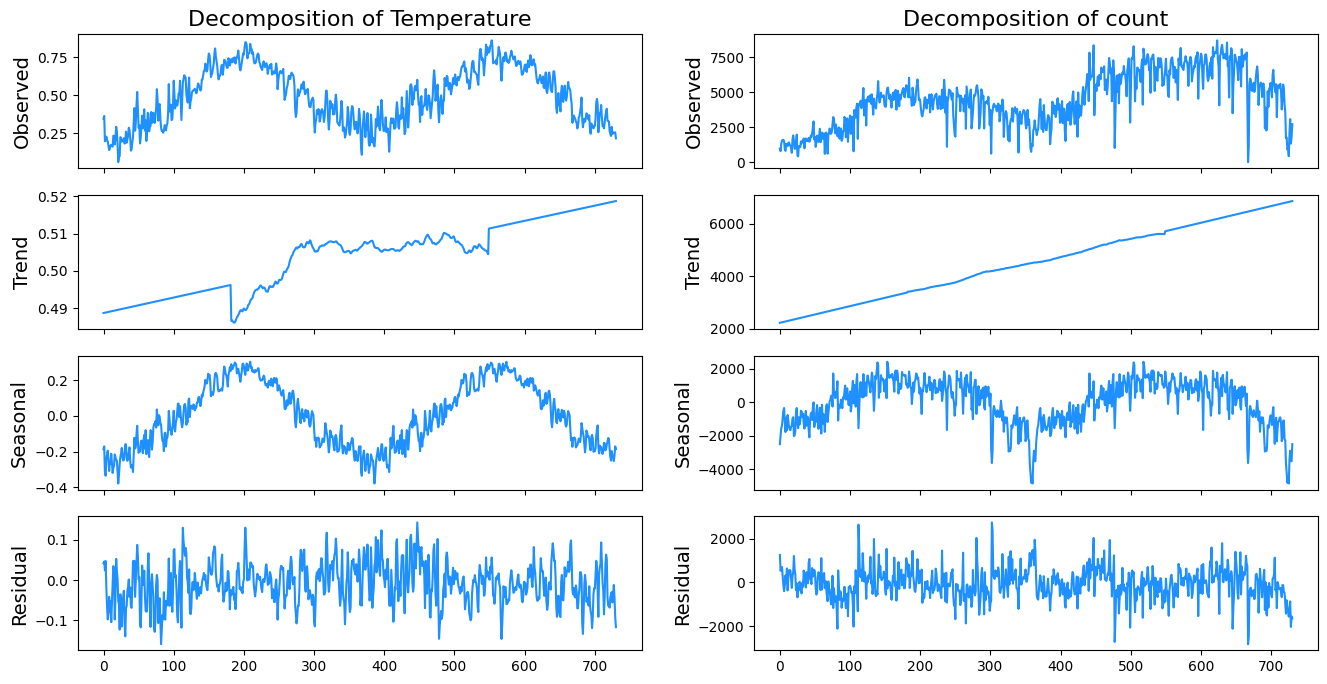

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(day_df.temperature, period=365, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)

ax[0,1].set_title('Decomposition of count', fontsize=16)
res = seasonal_decompose(day_df['count'], period=365, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

## <span style="color:powderblue">**Data Visualization**</span>

### <span style="color:lightcyan">**Data visualization over time**</span>

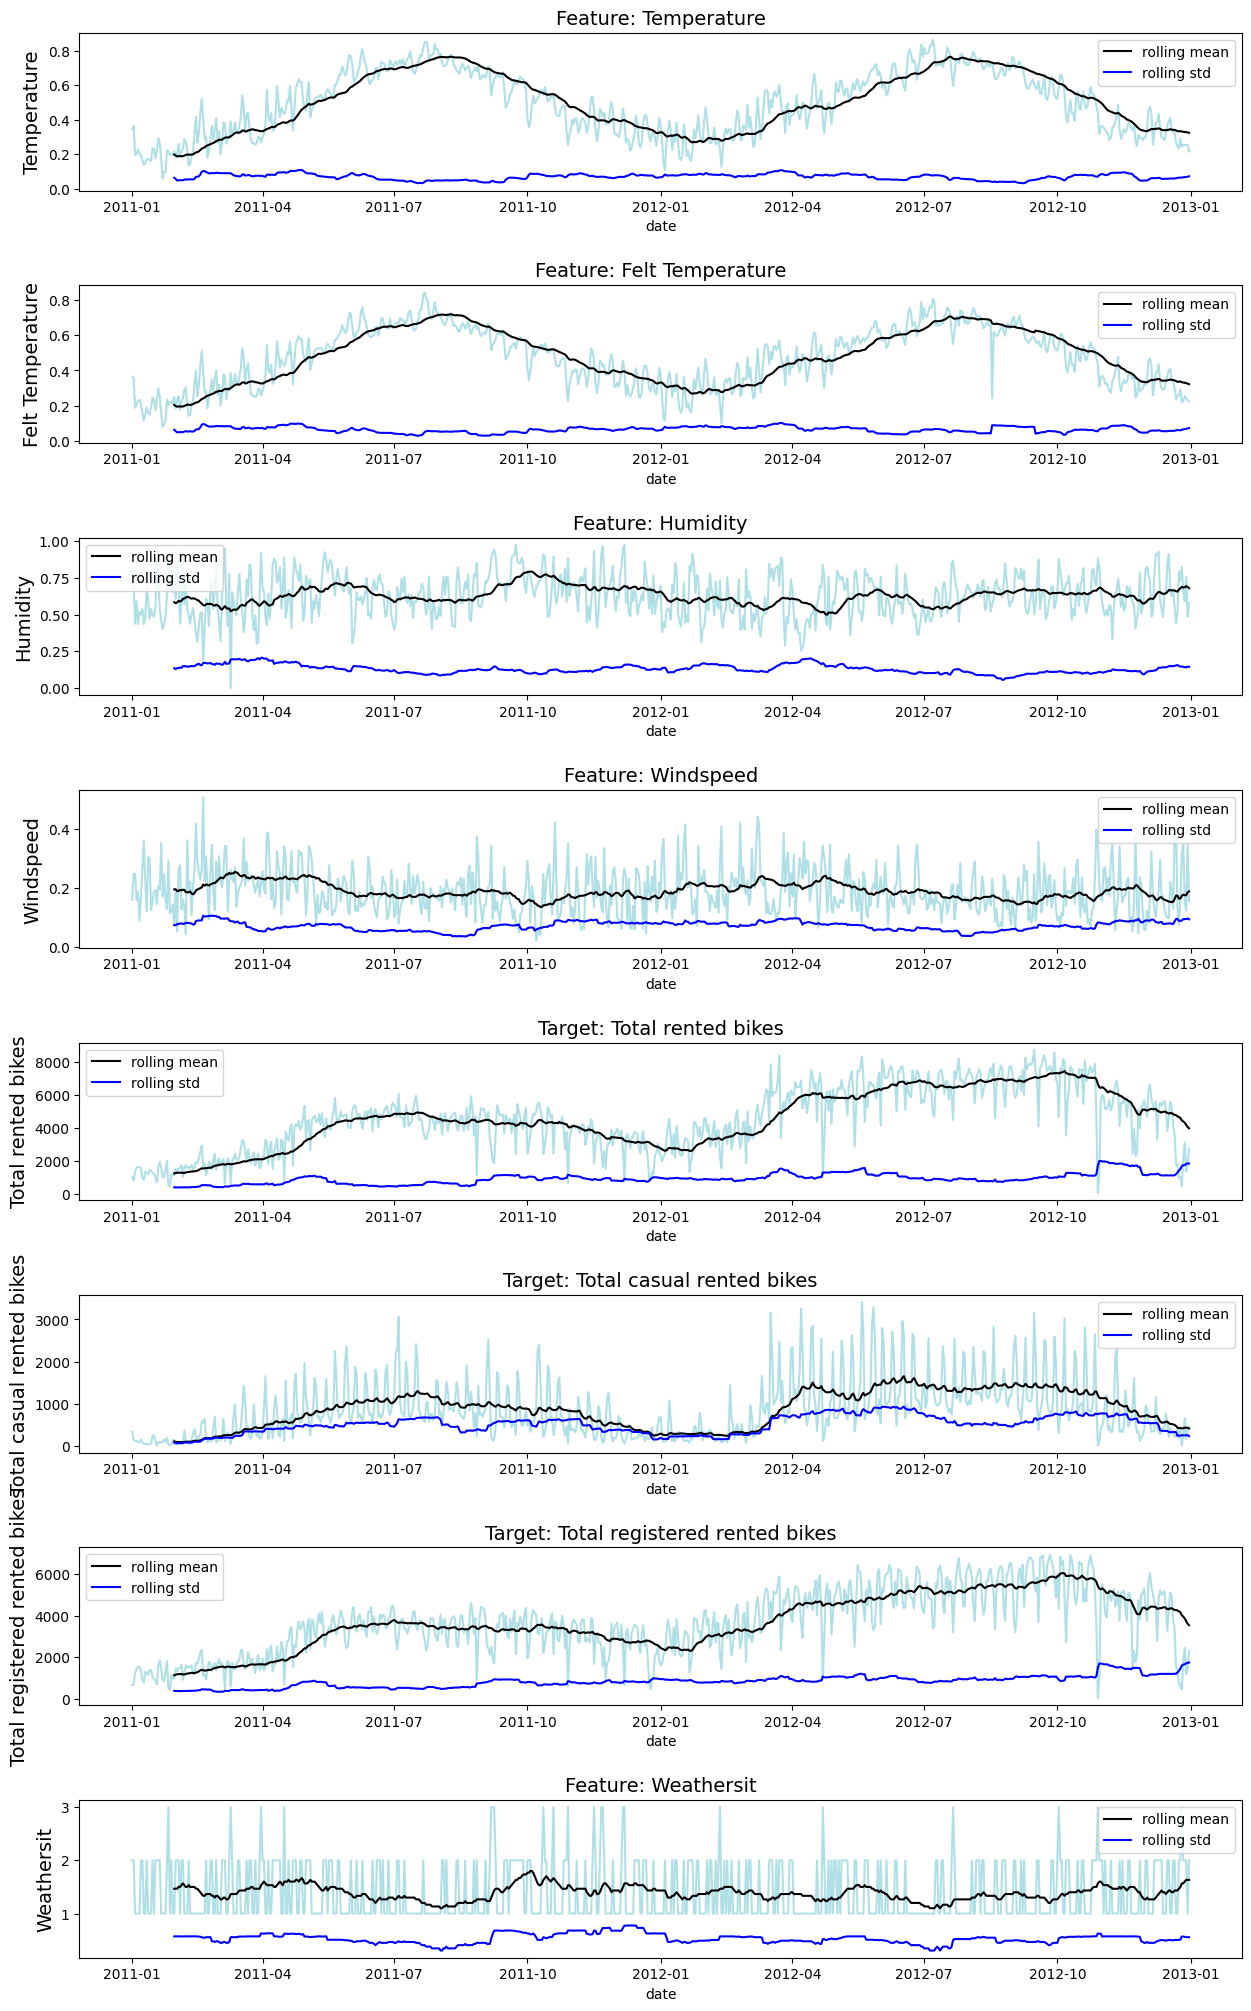

In [ ]:
rolling_window = 30
f, ax = plt.subplots(nrows=8, ncols=1, figsize=(15, 25))

sns.lineplot(x=day_df.date, y=day_df.temperature, ax=ax[0], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).mean(), ax=ax[0], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).std(), ax=ax[0], color='blue', label='rolling std')
ax[0].set_title('Feature: Temperature', fontsize=14)
ax[0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.felt_temperature, ax=ax[1], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).mean(), ax=ax[1], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).std(), ax=ax[1], color='blue', label='rolling std')
ax[1].set_title('Feature: Felt Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Felt Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.humidity, ax=ax[2], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).mean(), ax=ax[2], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).std(), ax=ax[2], color='blue', label='rolling std')
ax[2].set_title('Feature: Humidity', fontsize=14)
ax[2].set_ylabel(ylabel='Humidity', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.windspeed, ax=ax[3], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).mean(), ax=ax[3], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).std(), ax=ax[3], color='blue', label='rolling std')
ax[3].set_title('Feature: Windspeed', fontsize=14)
ax[3].set_ylabel(ylabel='Windspeed', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df["count"], ax=ax[4], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).mean(), ax=ax[4], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).std(), ax=ax[4], color='blue', label='rolling std')
ax[4].set_title('Target: Total rented bikes', fontsize=14)
ax[4].set_ylabel(ylabel='Total rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.casual, ax=ax[5], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).mean(), ax=ax[5], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).std(), ax=ax[5], color='blue', label='rolling std')
ax[5].set_title('Target: Total casual rented bikes', fontsize=14)
ax[5].set_ylabel(ylabel='Total casual rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.registered, ax=ax[6], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).mean(), ax=ax[6], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).std(), ax=ax[6], color='blue', label='rolling std')
ax[6].set_title('Target: Total registered rented bikes', fontsize=14)
ax[6].set_ylabel(ylabel='Total registered rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.weathersit, ax=ax[7], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.weathersit.rolling(rolling_window).mean(), ax=ax[7], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.weathersit.rolling(rolling_window).std(), ax=ax[7], color='blue', label='rolling std')
ax[7].set_title('Feature: Weathersit', fontsize=14)
ax[7].set_ylabel(ylabel='Weathersit', fontsize=14)

plt.subplots_adjust(hspace=0.6)
plt.show()

Trend and seasonality : ARIMA model not best suited for this as it assumes that underlying data is stationary (constant mean and not time-dependent, constant variance and not time dependent, constant covariance and not time-dependent) which is not the case here), strong seasonality for temperatures, for rentals, debatable for windspeed and humidity

### <span style="color:lightcyan">**Focus on Days**</span>

In [ ]:
#day_df.count()
#day_df[["cnt","casual","registered"]].describe().round(1)

#### **Distribution of Bike Rentals**

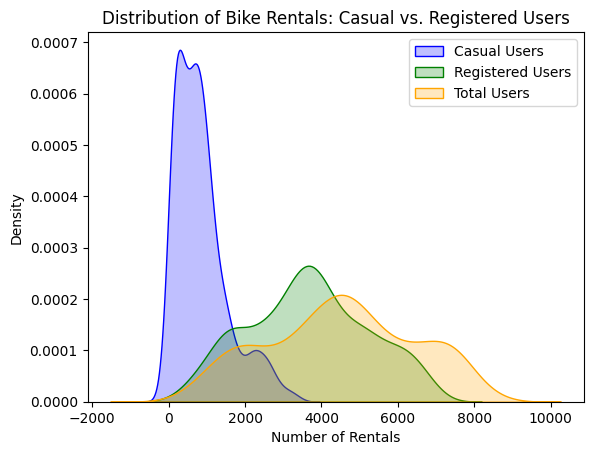

In [ ]:
sns.kdeplot(day_df['casual'], fill=True, label='Casual Users', color='blue')
sns.kdeplot(day_df['registered'], fill=True, label='Registered Users', color='green')
sns.kdeplot(day_df['count'], fill=True, label="Total Users", color='orange')
plt.title("Distribution of Bike Rentals: Casual vs. Registered Users")
plt.xlabel("Number of Rentals")
plt.ylabel("Density")
plt.legend()

#### **Bike rentals over time by season**

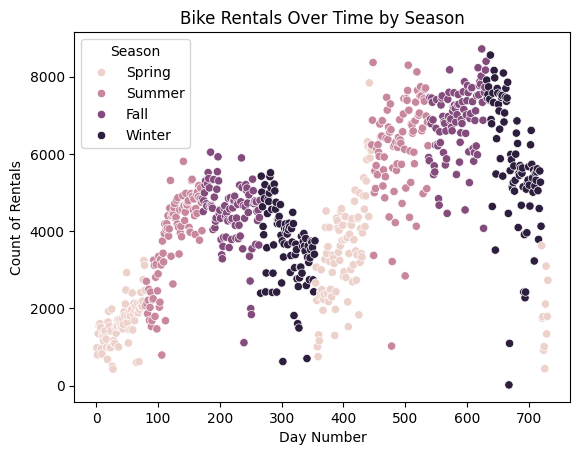

In [ ]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["season"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Season")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Season", labels=["Spring", "Summer", "Fall", "Winter"])

#### **Bike rentals per weekdays**

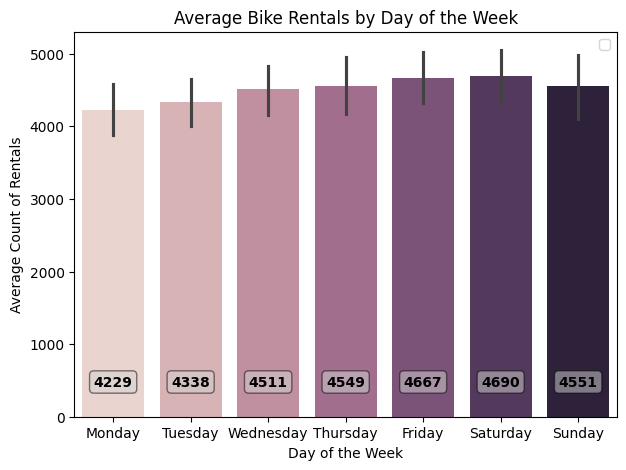

In [ ]:
plt.figure(figsize=(7,5))
barplot = sns.barplot(data=day_df, x="weekday", y="count", hue=day_df["weekday"])
plt.title("Average Bike Rentals by Day of the Week")
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Average Count of Rentals")
plt.legend([], [])

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}',
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center',
                         fontsize=10, color='black',
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rentals by temperature**

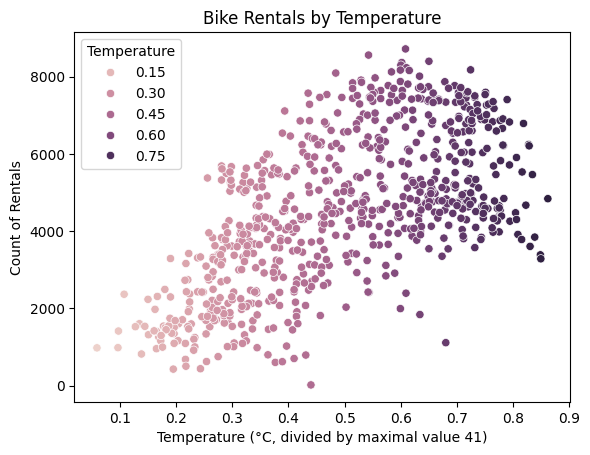

In [ ]:
sns.scatterplot(day_df,x="temperature",y="count",hue=day_df["temperature"])
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature")

Text(15.875000000000009, 0.5, 'Count of Rentals')

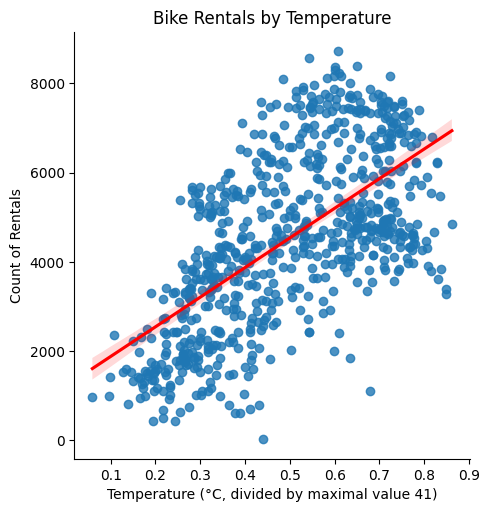

In [ ]:
sns.lmplot(data=day_df, x="temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")

#### **Bike rentals by temperature felt**

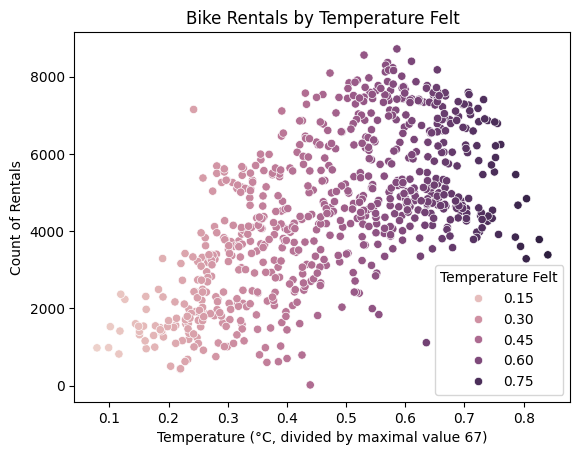

In [ ]:
sns.scatterplot(day_df,x="felt_temperature",y="count",hue=day_df["felt_temperature"])
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature Felt")

Text(15.875000000000009, 0.5, 'Count of Rentals')

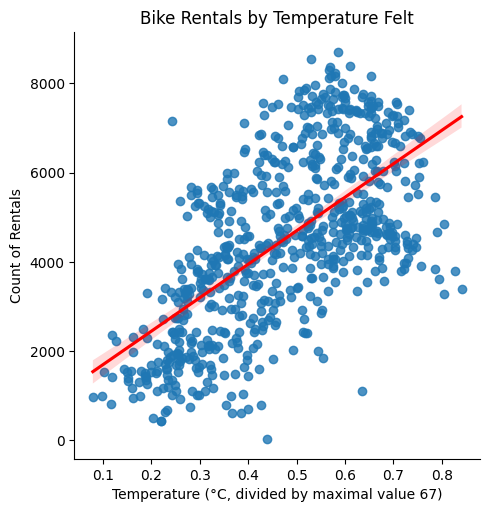

In [ ]:
sns.lmplot(data=day_df, x="felt_temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")

Clear correlation between temperature and bike rental amount (shocking)

#### **Bike rentals by humidity**

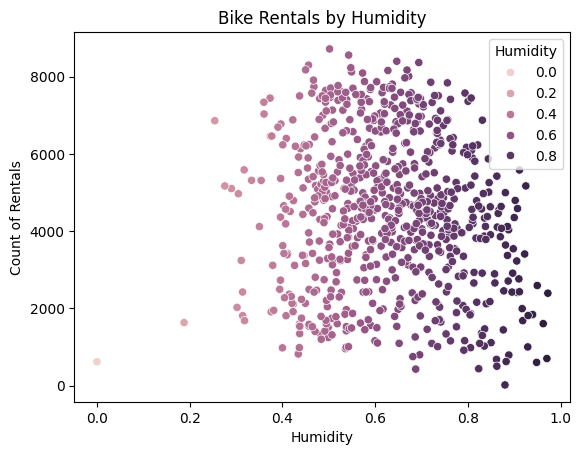

In [ ]:
sns.scatterplot(day_df,x="humidity",y="count",hue=day_df["humidity"])
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")
plt.legend(title="Humidity")

Text(15.875000000000009, 0.5, 'Count of Rentals')

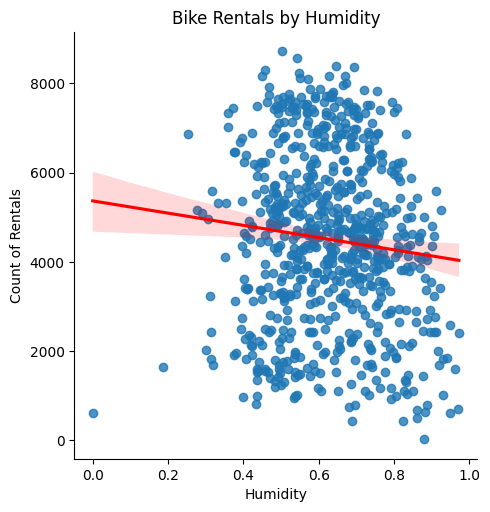

In [ ]:
sns.lmplot(data=day_df, x="humidity", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")

#### **Bike rentals by weather conditions**

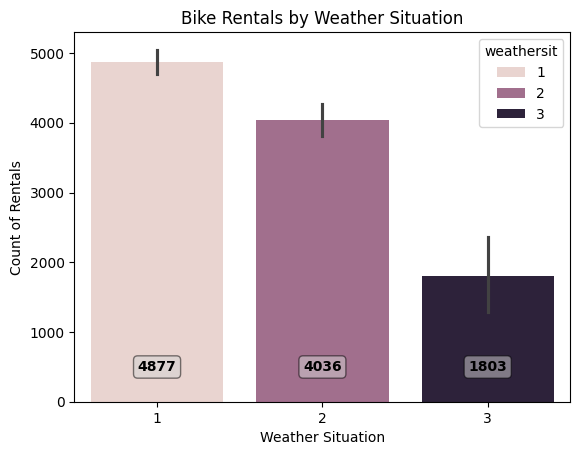

In [ ]:
barplot = sns.barplot(data=day_df, x="weathersit", y="count", hue=day_df["weathersit"])
plt.title("Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Count of Rentals")

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}',
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center',
                         fontsize=10, color='black',
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rental depending on wether the days are holidays or not**

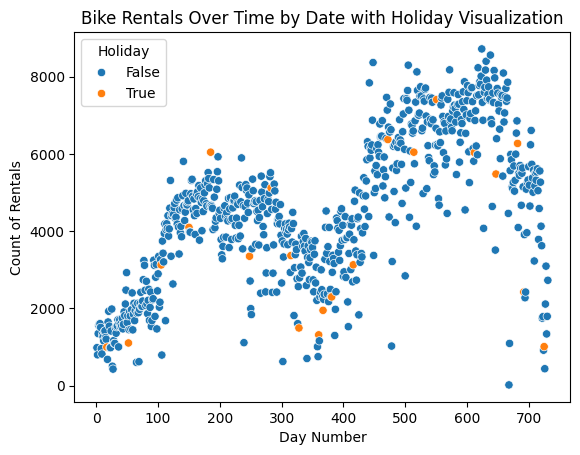

In [ ]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["holiday"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Date with Holiday Visualization")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Holiday", labels=["False","True"])

No clear influence of holidays on the bike rental amount

### <span style="color:lightcyan">**Focus on Hours**</span>

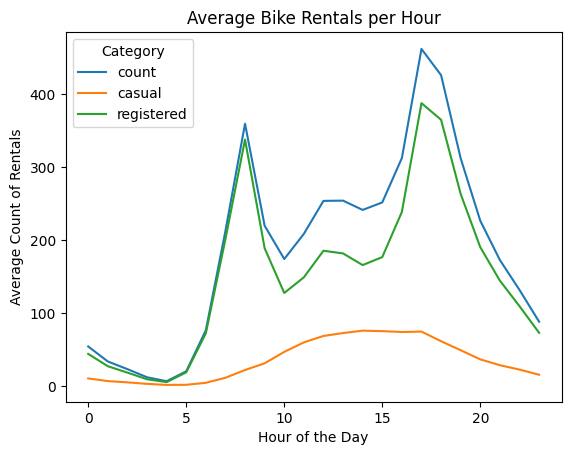

In [ ]:
hourly_rentals = hour_df.groupby("hour")["count"].mean()
hourly_casual =  hour_df.groupby("hour")["casual"].mean()
hourly_registered =  hour_df.groupby("hour")["registered"].mean()
hourly_rentals.plot(kind='line')
hourly_casual.plot(kind='line')
hourly_registered.plot(kind='line')
plt.title("Average Bike Rentals per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Count of Rentals")
plt.legend(title="Category")
plt.grid(False)

### <span style="color:lightcyan">**Correlation Analysis**</span>

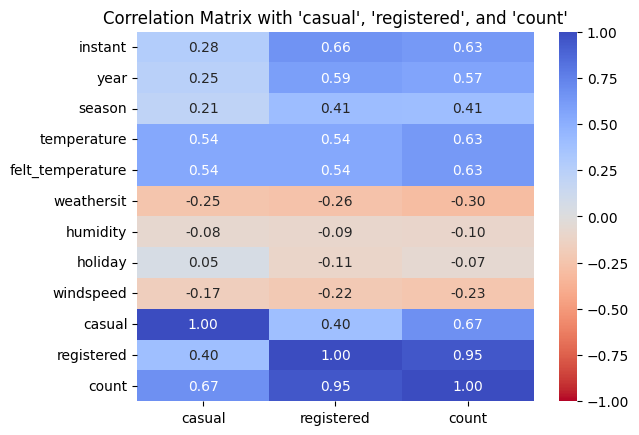

In [ ]:
correlation_matrix = day_df.corr()
# Keep only the correlations with 'casual', 'registered', and 'cnt'
filtered_corr_matrix = correlation_matrix.loc[['instant','year','season','temperature','felt_temperature','weathersit','humidity','holiday','windspeed','casual','registered','count'], ['casual', 'registered', 'count']].copy()

sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm_r", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix with 'casual', 'registered', and 'count'")
plt.show()

## <span style="color:powderblue">**Data Analysis**</span>

### <span style="color:lightcyan">**Cross Validation**</span>

In [ ]:
N_SPLITS = 3

X = day_df.date
y = day_df['count']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

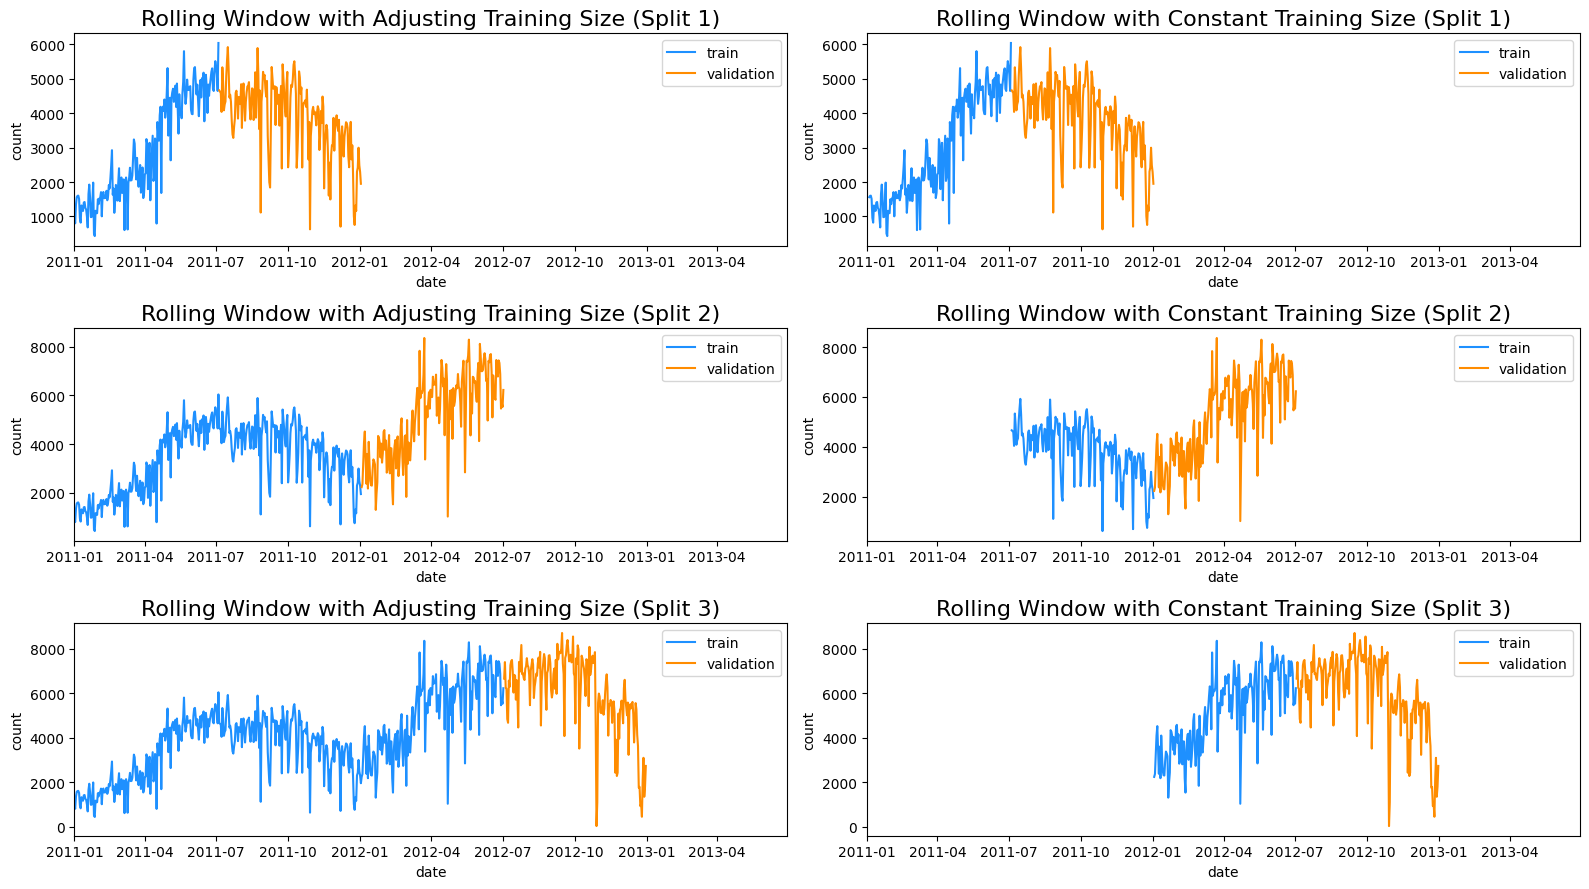

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2011, 1, 1), date(2013, 6, 30)])
    ax[i, 1].set_xlim([date(2011, 1, 1), date(2013, 6, 30)])
plt.tight_layout()
plt.show()

## <span style="color:powderblue">**Machine Learning**</span>

### <span style="color:lightcyan">**Univariate Time Series Forecasting**</span>

In [ ]:
def MAE(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    relative_mae = (mae / np.mean(y_test)) * 100
    return mae, relative_mae

def RMSE(y_test,y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    relative_rmse = (rmse / np.mean(y_test)) * 100
    return rmse, relative_rmse

### <span style="color:lightcyan">**Stochastic Models**</span>

#### **Naive Approach**

In [ ]:
def naive_model(y_train, test_length):
    """
    Naive model that predicts the last observed value in the training set for each test set point.
    """
    # Use the last observed value in y_train to make predictions for the entire test set
    last_value = y_train.iloc[-1]
    y_pred = np.full(test_length, last_value)
    return y_pred

In [ ]:
# Initialize TimeSeriesSplit with the desired number of splits
n_splits = 5  # Adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store MAE and RMSE for each fold
mae_scores = []
rmse_scores = []
# Perform cross-validation
for train_index, test_index in tscv.split(day_df):
    # Split the data into training and validation sets
    X_train, X_test = day_df.iloc[train_index], day_df.iloc[test_index]
    y_train, y_test = X_train["count"], X_test["count"]

    # Naive prediction approach: use the last observed value in the training set for all predictions
    y_pred = naive_model(y_train,len(y_test))

    # Calculate MAE and RMSE for this fold
    mae, relative_mae = MAE(y_test,y_pred)
    rmse, relative_rmse= RMSE(y_test,y_pred)

    # Append metrics for this fold
    mae_scores.append(relative_mae)
    rmse_scores.append(relative_rmse)

# Calculate the average MAE and RMSE across all folds
average_relative_mae = np.mean(mae_scores)
average_relative_rmse = np.mean(rmse_scores)

print(f"Average Relative MAE across folds: {average_relative_mae:.2f}%")
print(f"Average Relative RMSE across folds: {average_relative_rmse:.2f}%")

Average Relative MAE across folds: 28.53%
Average Relative RMSE across folds: 35.11%


#### **Moving Average**

In [ ]:
def moving_average_model(y_train, test_length, window_size):
    """
    Moving average model that predicts the average of the last 'window_size' values in the training set
    for each test set point.
    """
    # Calculate the moving average of the last 'window_size' values
    moving_avg = y_train.iloc[-window_size:].mean()
    y_pred = np.full(test_length, moving_avg)
    return y_pred

In [ ]:
# Initialize TimeSeriesSplit with the desired number of splits
n_splits = 5  # Adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Set the window size for the moving average
window_size = 7  # This could represent the past week in daily data

# Store MAE and RMSE for each fold
mae_scores = []
rmse_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(day_df):
    # Split the data into training and validation sets
    X_train, X_test = day_df.iloc[train_index], day_df.iloc[test_index]
    y_train, y_test = X_train["count"], X_test["count"]

    # Generate predictions using the moving average model
    y_pred = moving_average_model(y_train, len(y_test), window_size)

    # Calculate MAE and RMSE for this fold
    mae, relative_mae = MAE(y_test,y_pred)
    rmse, relative_rmse= RMSE(y_test,y_pred)

    # Append metrics for this fold
    mae_scores.append(relative_mae)
    rmse_scores.append(relative_rmse)

# Calculate the average MAE and RMSE across all folds
average_relative_mae = np.mean(mae_scores)
average_relative_rmse = np.mean(rmse_scores)

print(f"Average Relative MAE across folds: {average_relative_mae:.2f}%")
print(f"Average Relative RMSE across folds: {average_relative_rmse:.2f}%")

Average Relative MAE across folds: 29.83%
Average Relative RMSE across folds: 36.68%


#### **Exponential Smoothing**

In [ ]:
def exponential_smoothing_with_trend(y_train, test_length, alpha=0.3, beta=0.1):
    """
    Double Exponential Smoothing model that uses both level and trend components to forecast each test point.
    """
    # Apply Holt's Linear Trend model to the training data
    model = Holt(y_train).fit(smoothing_level=alpha, smoothing_slope=beta)

    # Forecast the test_length steps
    y_pred = model.forecast(test_length)
    return y_pred

In [ ]:
# Initialize TimeSeriesSplit with the desired number of splits
n_splits = 5  # Adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Set the smoothing factors for level and trend
alpha = 0.3  # Smoothing factor for level
beta = 0.1   # Smoothing factor for trend

# Store MAE and RMSE for each fold
mae_scores = []
rmse_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(day_df):
    # Split the data into training and validation sets
    X_train, X_test = day_df.iloc[train_index], day_df.iloc[test_index]
    y_train, y_test = X_train["count"], X_test["count"]

    # Generate predictions using the double exponential smoothing model
    y_pred = exponential_smoothing_with_trend(y_train, len(y_test), alpha=alpha, beta=beta)

    # Calculate MAE and RMSE for this fold
    mae, relative_mae = MAE(y_test,y_pred)
    rmse, relative_rmse= RMSE(y_test,y_pred)

    # Append metrics for this fold
    mae_scores.append(relative_mae)
    rmse_scores.append(relative_rmse)

# Calculate the average MAE and RMSE across all folds
average_relative_mae = np.mean(mae_scores)
average_relative_rmse = np.mean(rmse_scores)

print(f"Average Relative MAE across folds: {average_relative_mae:.2f}%")
print(f"Average Relative RMSE across folds: {average_relative_rmse:.2f}%")

# Test des différents modèles

In [ ]:

# Charger les données
bike_data = pd.read_csv('/content/day.csv')

# Prétraitement des données
bike_data['dteday'] = pd.to_datetime(bike_data['dteday'])
bike_data.set_index('dteday', inplace=True)

# Encodage cyclique des variables temporelles
bike_data['mnth_sin'] = np.sin(2 * np.pi * bike_data['mnth'] / 12)
bike_data['mnth_cos'] = np.cos(2 * np.pi * bike_data['mnth'] / 12)
bike_data['weekday_sin'] = np.sin(2 * np.pi * bike_data['weekday'] / 7)
bike_data['weekday_cos'] = np.cos(2 * np.pi * bike_data['weekday'] / 7)

# Sélection des caractéristiques pertinentes, y compris les nouvelles colonnes encodées
features = ['season', 'yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
            'mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
target = 'cnt'

# Séparation des données en jeu d'entraînement et jeu de test
X = bike_data[features]
y = bike_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Fonction utilitaire pour calculer les KPI (MAE, RMSE, biais)
def compute_KPIs(Y_train, F_train, Y_test, F_test, name=''):
    if F_train.shape != Y_train.shape:
        F_train = F_train.reshape(-1, 1)
        F_test = F_test.reshape(-1, 1)

    # Calcul des indicateurs de performance
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name
    df.loc['Train', 'MAE'] = 100 * np.mean(abs(F_train - Y_train)) / np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100 * np.sqrt(np.mean((F_train - Y_train) ** 2)) / np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100 * np.mean((F_train - Y_train)) / np.mean(Y_train)
    df.loc['Test', 'MAE'] = 100 * np.mean(abs(F_test - Y_test)) / np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100 * np.sqrt(np.mean((F_test - Y_test) ** 2)) / np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100 * np.mean((F_test - Y_test)) / np.mean(Y_test)
    df = df.astype(float).round(2)  # Arrondir pour un affichage plus lisible
    print(df)
    return df

# Initialiser un dictionnaire pour stocker les KPI de chaque modèle
kpi_results = {}




1. Regression linéaire


=== Régression Linéaire ===
                     MAE   RMSE  Bias
Linear Regression                    
Train              13.80  18.87  0.00
Test               14.11  18.95  0.97


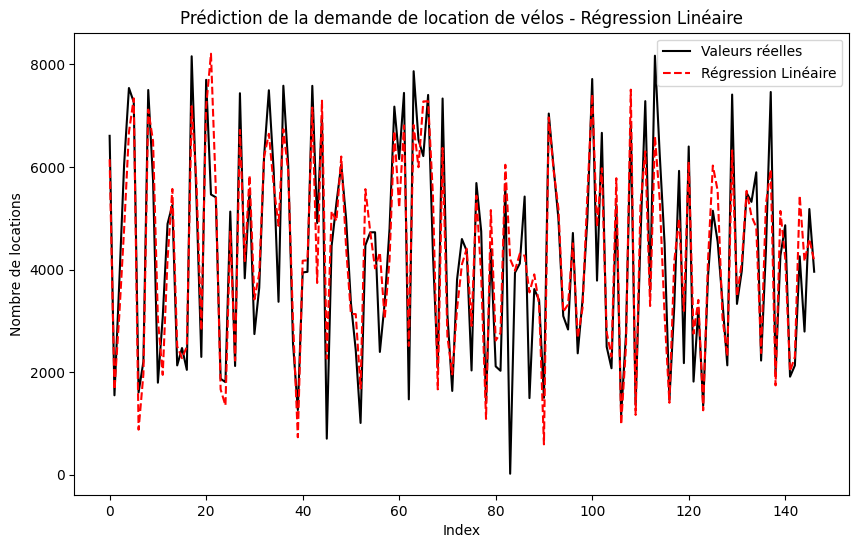

In [ ]:
### 1. Régression linéaire
print("\n=== Régression Linéaire ===")
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_lr = linear_model.predict(X_train)
y_pred_test_lr = linear_model.predict(X_test)
kpi_results['Linear Regression'] = compute_KPIs(y_train, y_pred_train_lr, y_test, y_pred_test_lr, name='Linear Regression')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_lr, label='Régression Linéaire', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Régression Linéaire')
plt.legend()
plt.show()




2. Arbre de décision


=== Arbre de Décision ===
                 MAE   RMSE  Bias
Decision Tree                    
Train           2.85   5.38  0.00
Test           13.90  22.52  0.98


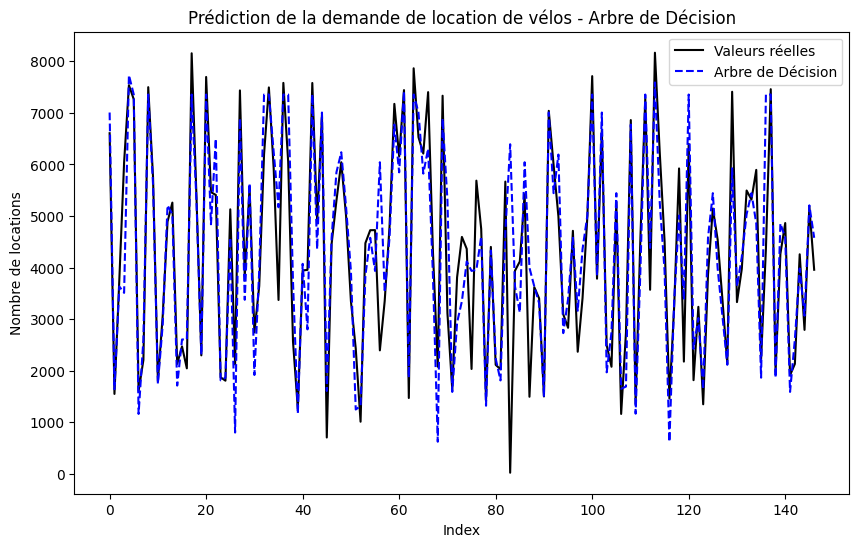

In [ ]:
### 2. Arbre de décision
print("\n=== Arbre de Décision ===")
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_train_tree = tree_model.predict(X_train)
y_pred_test_tree = tree_model.predict(X_test)
kpi_results['Decision Tree'] = compute_KPIs(y_train, y_pred_train_tree, y_test, y_pred_test_tree, name='Decision Tree')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_tree, label='Arbre de Décision', linestyle='--', color='blue')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Arbre de Décision')
plt.legend()
plt.show()

3. Forêt aléatoire


=== Forêt Aléatoire ===
                MAE   RMSE  Bias
Random Forest                   
Train          3.93   5.63  0.23
Test           9.88  15.62  0.60


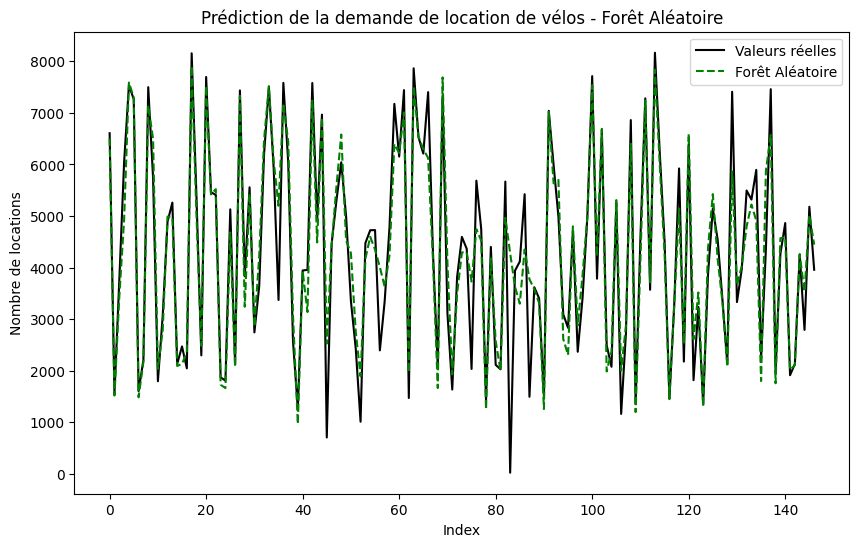

In [ ]:
### 3. Forêt aléatoire
print("\n=== Forêt Aléatoire ===")
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
y_pred_train_forest = forest_model.predict(X_train)
y_pred_test_forest = forest_model.predict(X_test)
kpi_results['Random Forest'] = compute_KPIs(y_train, y_pred_train_forest, y_test, y_pred_test_forest, name='Random Forest')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_forest, label='Forêt Aléatoire', linestyle='--', color='green')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Forêt Aléatoire')
plt.legend()
plt.show()

4. Extra Trees Regressor


=== Extra Trees Regressor ===
               MAE   RMSE  Bias
Extra Trees                    
Train         0.00   0.00  0.00
Test         10.14  15.87  0.66


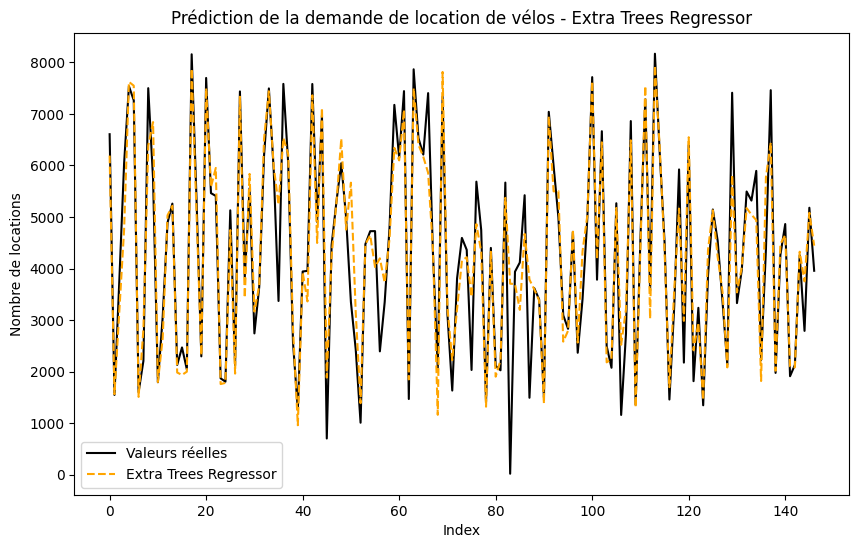

In [ ]:

### 4. Extra Trees Regressor
print("\n=== Extra Trees Regressor ===")
extra_trees_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
extra_trees_model.fit(X_train, y_train)
y_pred_train_extra = extra_trees_model.predict(X_train)
y_pred_test_extra = extra_trees_model.predict(X_test)
kpi_results['Extra Trees'] = compute_KPIs(y_train, y_pred_train_extra, y_test, y_pred_test_extra, name='Extra Trees')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_extra, label='Extra Trees Regressor', linestyle='--', color='orange')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Extra Trees Regressor')
plt.legend()
plt.show()

5. LGBM


=== LightGBM Regressor ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
            MAE   RMSE  Bias
LightGBM                    
Train      3.88   5.80 -0.00
Test      10.00  15.12  0.48


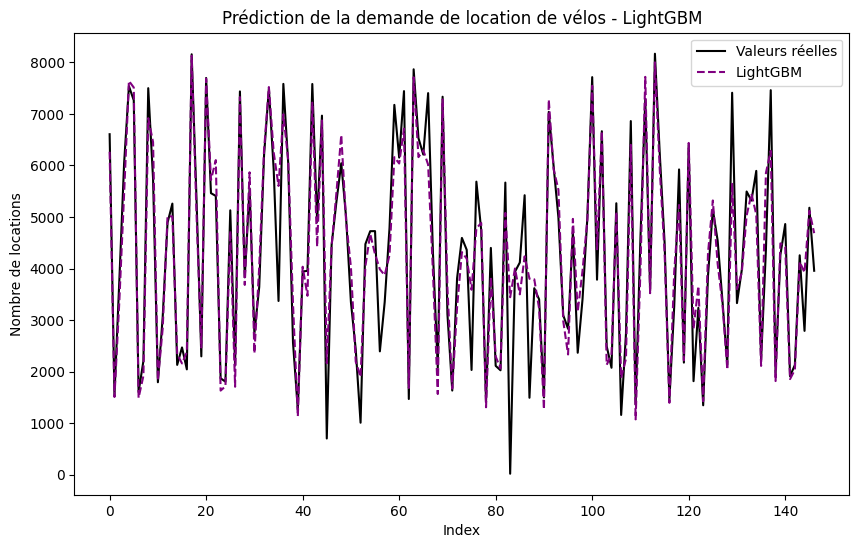

In [ ]:
### 5. LightGBM (LGBM)
print("\n=== LightGBM Regressor ===")
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'num_leaves': [20, 31, 50],
    'min_child_samples': [5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5]
}
lgbm_model = LGBMRegressor(objective='regression', random_state=42,verbosity=-1)
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1, verbose=2)
random_search_lgbm.fit(X_train, y_train)

best_lgbm_model = random_search_lgbm.best_estimator_
y_pred_train_lgbm = best_lgbm_model.predict(X_train)
y_pred_test_lgbm = best_lgbm_model.predict(X_test)
kpi_results['LightGBM'] = compute_KPIs(y_train, y_pred_train_lgbm, y_test, y_pred_test_lgbm, name='LightGBM')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_lgbm, label='LightGBM', linestyle='--', color='purple')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - LightGBM')
plt.legend()
plt.show()

6. XGBoost



=== XGBoost Regressor ===
           MAE   RMSE  Bias
XGBoost                    
Train     0.25   0.35  0.00
Test     10.21  15.24  0.23


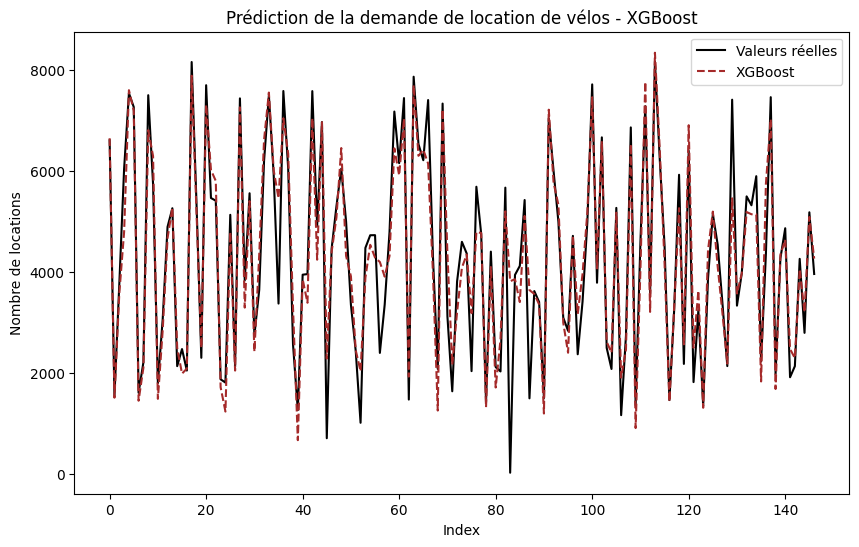

In [ ]:
# 6. XGBoost
print("\n=== XGBoost Regressor ===")

# Création du modèle XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Ajustement du modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédiction sur les jeux d'entraînement et de test
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Calcul des KPI pour XGBoost
kpi_results['XGBoost'] = compute_KPIs(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb, name='XGBoost')

# Visualisation des résultats pour XGBoost
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valeurs réelles', color='black')
plt.plot(y_pred_test_xgb, label='XGBoost', linestyle='--', color='brown')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - XGBoost')
plt.legend()
plt.show()

7. Naïf


=== Naïf Regressor ===


<ipython-input-18-df4a3a8608fb>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_train_naive = y_train.shift(1).fillna(method='bfill')  # Utilisation de la dernière valeur connue pour l'entraînement


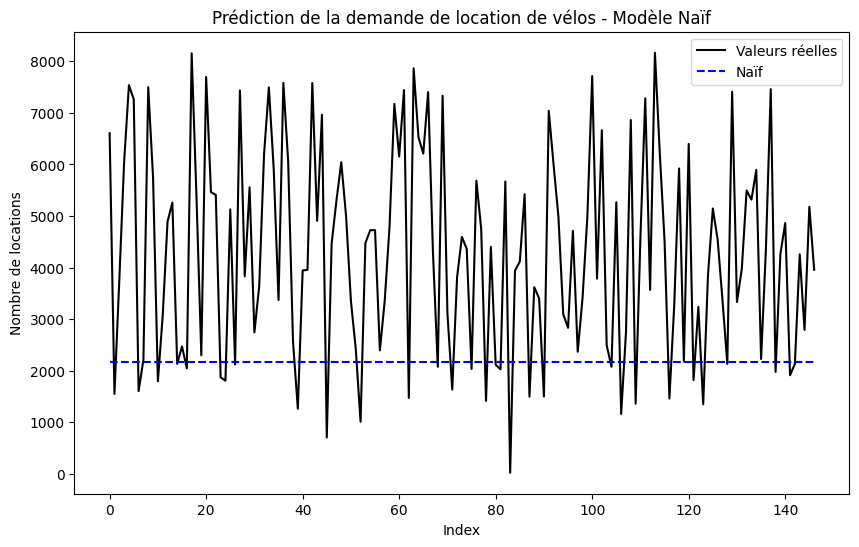

In [ ]:
# 7. Modèle Naïf
print("\n=== Naïf Regressor ===")

# Le modèle naïf prend la dernière valeur de la série d'entraînement comme prédiction pour tout le futur
y_pred_train_naive = y_train.shift(1).fillna(method='bfill')  # Utilisation de la dernière valeur connue pour l'entraînement
y_pred_test_naive = y_train.iloc[-1]  # Utilisation de la dernière valeur de l'entraînement comme prédiction constante pour le test
y_pred_test_naive = pd.Series([y_pred_test_naive] * len(y_test), index=y_test.index)

# Calcul des KPI pour le modèle naïf
#kpi_results['Naïf'] = compute_KPIs(y_train, y_pred_train_naive, y_test, y_pred_test_naive, name='Naïf')

# Visualisation des résultats pour le modèle naïf
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label='Valeurs réelles', color='black')
plt.plot(range(len(y_test)), y_pred_test_naive.values, label='Naïf', linestyle='--', color='blue')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Modèle Naïf')
plt.legend()
plt.show()



8. Smoothing exponentiel



=== Exponential Smoothing ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


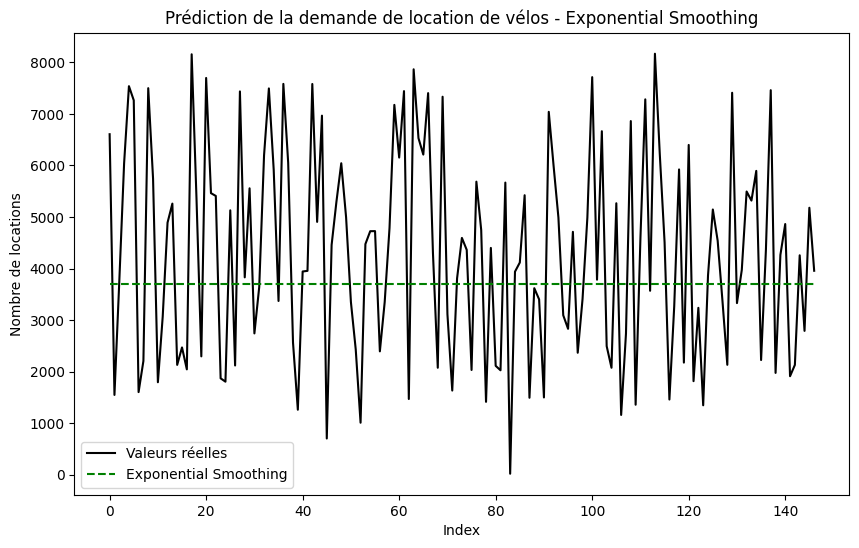

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 8. Exponential Smoothing
print("\n=== Exponential Smoothing ===")

# Création et ajustement du modèle de lissage exponentiel simple
exp_smoothing_model = SimpleExpSmoothing(y_train).fit(smoothing_level=0.2, optimized=False)

# Prédiction sur les jeux d'entraînement et de test
y_pred_train_exp_smoothing = exp_smoothing_model.fittedvalues
y_pred_test_exp_smoothing = exp_smoothing_model.forecast(len(y_test))

# Calcul des KPI pour le lissage exponentiel simple
#kpi_results['Exponential Smoothing'] = compute_KPIs(y_train, y_pred_train_exp_smoothing, y_test, y_pred_test_exp_smoothing, name='Exponential Smoothing')

# Visualisation des résultats pour Exponential Smoothing
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label='Valeurs réelles', color='black')
plt.plot(range(len(y_test)), y_pred_test_exp_smoothing.values, label='Exponential Smoothing', linestyle='--', color='green')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Exponential Smoothing')
plt.legend()
plt.show()


9. Moving Average


=== Moving Average Regressor ===


<ipython-input-16-38cd8eb4a6bd>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_train_moving_average = y_train.rolling(window=window_size).mean().fillna(method='bfill')


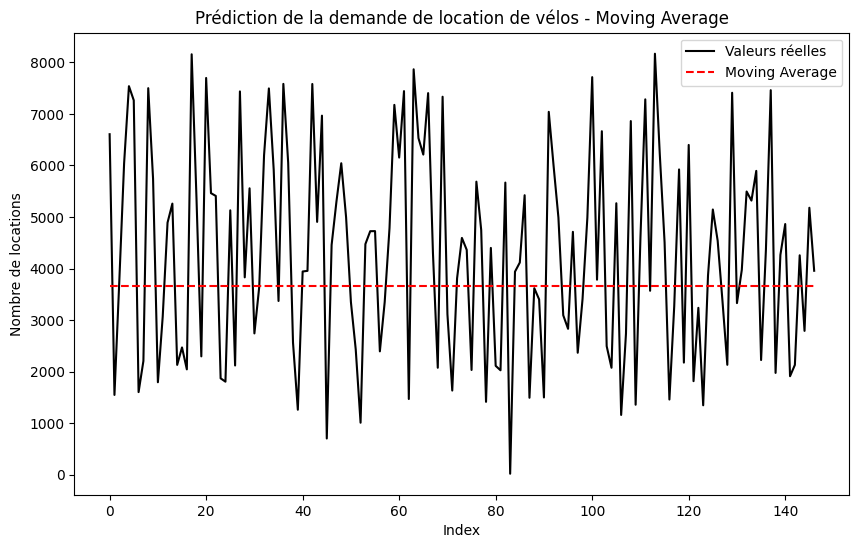

In [ ]:
# 11. Moving Average
print("\n=== Moving Average Regressor ===")

# Définir la fenêtre de la moyenne mobile
window_size = 3

# Prédiction pour l'entraînement : moyenne glissante sur les valeurs d'entraînement
y_pred_train_moving_average = y_train.rolling(window=window_size).mean().fillna(method='bfill')

# Prédiction pour le test : utiliser la moyenne des dernières valeurs de l'entraînement
last_values = y_train[-window_size:]
y_pred_test_moving_average = pd.Series([last_values.mean()] * len(y_test), index=y_test.index)

# Calcul des KPI pour la moyenne mobile
#kpi_results['Moving Average'] = compute_KPIs(y_train, y_pred_train_moving_average, y_test, y_pred_test_moving_average, name='Moving Average')

# Visualisation des résultats pour Moving Average
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label='Valeurs réelles', color='black')
plt.plot(range(len(y_test)), y_pred_test_moving_average.values, label='Moving Average', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Moving Average')
plt.legend()
plt.show()


Comparaison de tous les résultats

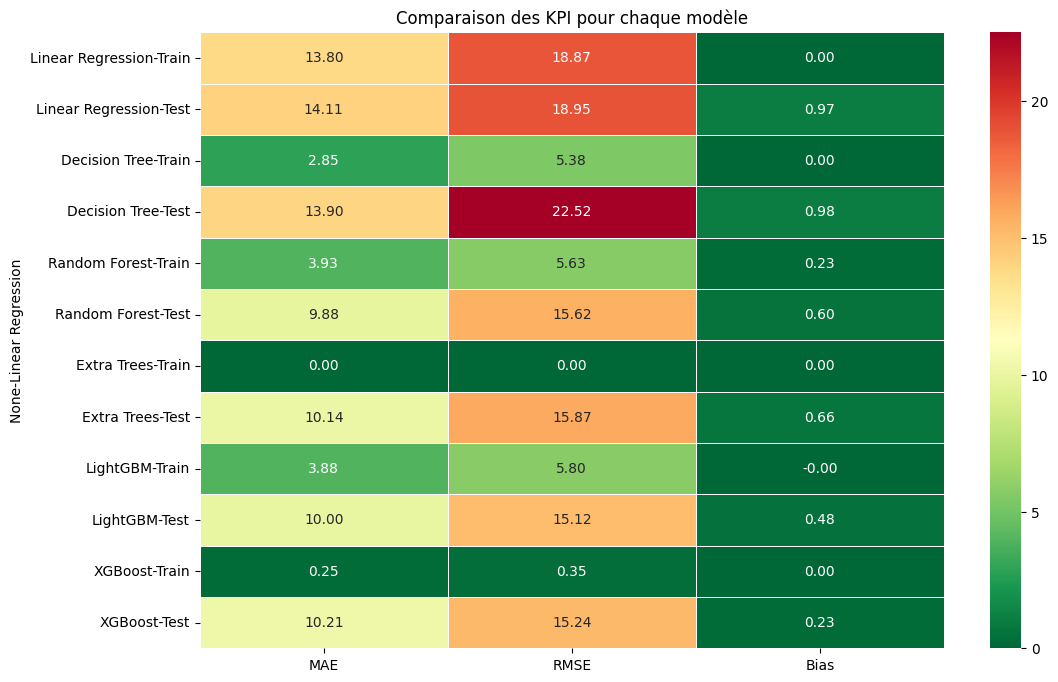

In [ ]:
# Combiner tous les KPI dans un seul DataFrame pour comparaison
kpi_combined = pd.concat(kpi_results, axis=0)

# Afficher les KPI avec un code couleur (le plus grand est le plus rouge)
plt.figure(figsize=(12, 8))
sns.heatmap(kpi_combined, annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt=".2f")
plt.title('Comparaison des KPI pour chaque modèle')
plt.show()

In [ ]:
# Fonction pour tester et visualiser l'impact des hyperparamètres
def test_hyperparameters(params_grid, X_train, y_train, X_test, y_test):
    results = []

    for n_estimators in params_grid['n_estimators']:
        for max_depth in params_grid['max_depth']:
            # Créer un modèle de Forêt Aléatoire avec les hyperparamètres donnés
            forest_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

            # Entraîner le modèle sur les données d'entraînement
            forest_model.fit(X_train, y_train)

            # Prédire sur les jeux d'entraînement et de test
            y_pred_train = forest_model.predict(X_train)
            y_pred_test = forest_model.predict(X_test)

            # Calcul des KPI
            kpi_df = compute_KPIs(y_train, y_pred_train, y_test, y_pred_test, name=f'n_estimators={n_estimators}, max_depth={max_depth}')

            # Calcul du score personnalisé (RMSE + MAE + |Bias|)
            score = kpi_df.loc['Test', 'RMSE'] + kpi_df.loc['Test', 'MAE'] + abs(kpi_df.loc['Test', 'Bias'])
            results.append({'n_estimators': n_estimators, 'max_depth': max_depth, 'score': score})

            # Affichage des résultats
            print(f'n_estimators={n_estimators}, max_depth={max_depth}, Score personnalisé: {score}')

    # Visualisation des résultats
    plt.figure(figsize=(12, 6))
    for max_depth in params_grid['max_depth']:
        depth_results = [r['score'] for r in results if r['max_depth'] == max_depth]
        estimators = [r['n_estimators'] for r in results if r['max_depth'] == max_depth]
        plt.plot(estimators, depth_results, label=f'max_depth={max_depth}', marker='o')

    plt.xlabel('Nombre d\'estimateurs (n_estimators)')
    plt.ylabel('Score personnalisé (RMSE + MAE + |Bias|)')
    plt.title('Impact des hyperparamètres sur la performance du modèle Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

# Définir la grille des hyperparamètres à tester
params_grid = {
    'n_estimators': [ 100, 180, 190, 200, 210, 250, 300],
    'max_depth': [10, 20, 25, 26, 27, 28, 29, 30, 31,32]
}

# Appeler la fonction pour tester et visualiser l'impact des hyperparamètres
test_hyperparameters(params_grid, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparamètres: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 10}
                           MAE   RMSE  Bias
Optimized Random Forest                    
Train                     5.17   7.23  0.21
Test                     11.48  16.88  0.99
Score personnalisé (RMSE + MAE + |Bias|) pour la Forêt Aléatoire optimisée: 29.349999999999998


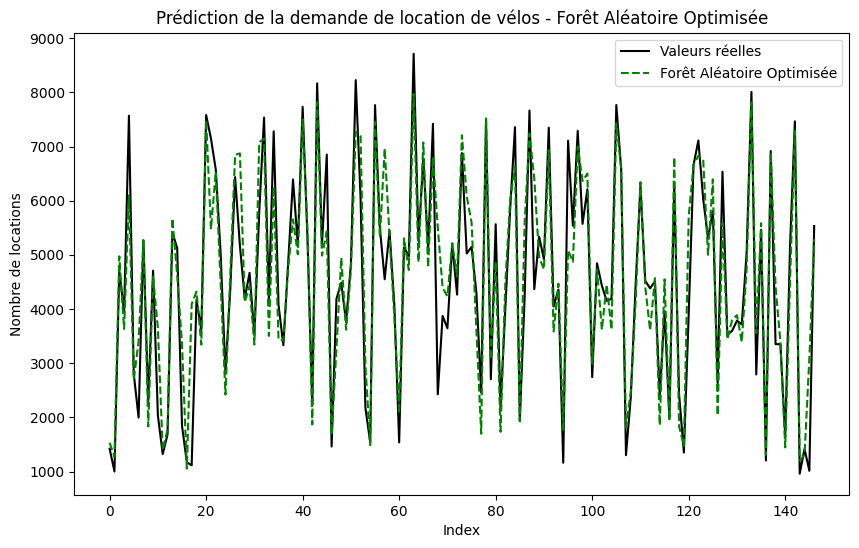

In [ ]:
# Importation des bibliothèques nécessaires
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Définir la grille des hyperparamètres à tester
param_grid = {
    'max_depth': [10, 20, 5, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [5, 10, 20, 50,100, 150],
}

# Utiliser RandomizedSearchCV pour rechercher les meilleurs hyperparamètres
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(),
                                   param_distributions=param_grid,
                                   n_iter=50, cv=3, verbose=2, n_jobs=-1)

# Ajuster le modèle sur les données d'entraînement
random_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
best_params = random_search.best_params_
print(f"Meilleurs hyperparamètres: {best_params}")

# Entraîner le modèle avec les meilleurs hyperparamètres
best_forest_model = random_search.best_estimator_
y_pred_train_forest = best_forest_model.predict(X_train)
y_pred_test_forest = best_forest_model.predict(X_test)

# Calcul des KPI pour le modèle optimisé
kpi_results['Optimized Random Forest'] = compute_KPIs(y_train, y_pred_train_forest, y_test, y_pred_test_forest, name='Optimized Random Forest')

# Calcul du score personnalisé (RMSE + MAE + |Bias|)
def custom_score(kpi_df):
    return kpi_df.loc['Test', 'RMSE'] + kpi_df.loc['Test', 'MAE'] + abs(kpi_df.loc['Test', 'Bias'])

# Afficher le score personnalisé pour le modèle optimisé
optimized_score = custom_score(kpi_results['Optimized Random Forest'])
print(f"Score personnalisé (RMSE + MAE + |Bias|) pour la Forêt Aléatoire optimisée: {optimized_score}")

# Visualisation des résultats pour le modèle optimisé
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label='Valeurs réelles', color='black')
plt.plot(range(len(y_test)), y_pred_test_forest, label='Forêt Aléatoire Optimisée', linestyle='--', color='green')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Forêt Aléatoire Optimisée')
plt.legend()
plt.show()


**Limite de l'analyse :**
- data set limité
- pas de mémoires des données : s'il a beaucoup plu, il peut y avoir des innondations et donc pas de vélo...
- spécificité à la région en fonction des habitudes : 5° peut paraitre très froid à Marseille mais c'est plus qu'acceptable à Stockholm
